In [20]:
from datetime import datetime, timedelta
from tinkoff.invest import CandleInterval, Client
from tinkoff.invest.schemas import CandleSource
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import os

load_dotenv()

True

In [21]:
TOKEN = os.getenv("TOKEN")
end_date = datetime.now() - timedelta(days=1)
start_date = end_date - relativedelta(months=12)
STOCK = "TCS00A107T19"
MOEX = "BBG004730JJ5"

data_candle_target = []
data_candle_index = []


In [22]:
with Client(TOKEN) as c:
    for candle in c.get_all_candles(
        instrument_id=STOCK,
        from_=start_date,
        to=end_date,
        interval=CandleInterval.CANDLE_INTERVAL_DAY,
        candle_source_type=CandleSource.CANDLE_SOURCE_UNSPECIFIED,
    ):
        data_candle_target.append({
            'date': candle.time.date(),
            'price': candle.close.units + candle.close.nano / 1e9,
        })

    for candle in c.get_all_candles(
        instrument_id=MOEX,
        from_=start_date,
        to=end_date,
        interval=CandleInterval.CANDLE_INTERVAL_DAY,
        candle_source_type=CandleSource.CANDLE_SOURCE_UNSPECIFIED,
    ):
        data_candle_index.append({
            'date': candle.time.date(),
            'price': candle.close.units + candle.close.nano / 1e9,
        })

target_df = pd.DataFrame(data_candle_target)
index_df = pd.DataFrame(data_candle_index)
target_df.set_index('date', inplace=True)
index_df.set_index('date', inplace=True)
target_df.sort_index(inplace=True)
index_df.sort_index(inplace=True)
general_df = target_df.merge(index_df, on='date', suffixes=("_target", "_index")    )


In [23]:
general_df["log_return_target"] = np.log(general_df["price_target"] / general_df["price_target"].shift())
general_df["log_return_index"] = np.log(general_df["price_index"] / general_df["price_index"].shift())
general_df.dropna(inplace=True)


In [29]:
A = np.vstack([general_df["log_return_index"], np.ones(len(general_df["log_return_index"]))]).T
b, a = np.linalg.lstsq(A, general_df["log_return_target"])[0]
print(round(b, 2), round(a, 3))

0.69 0.001


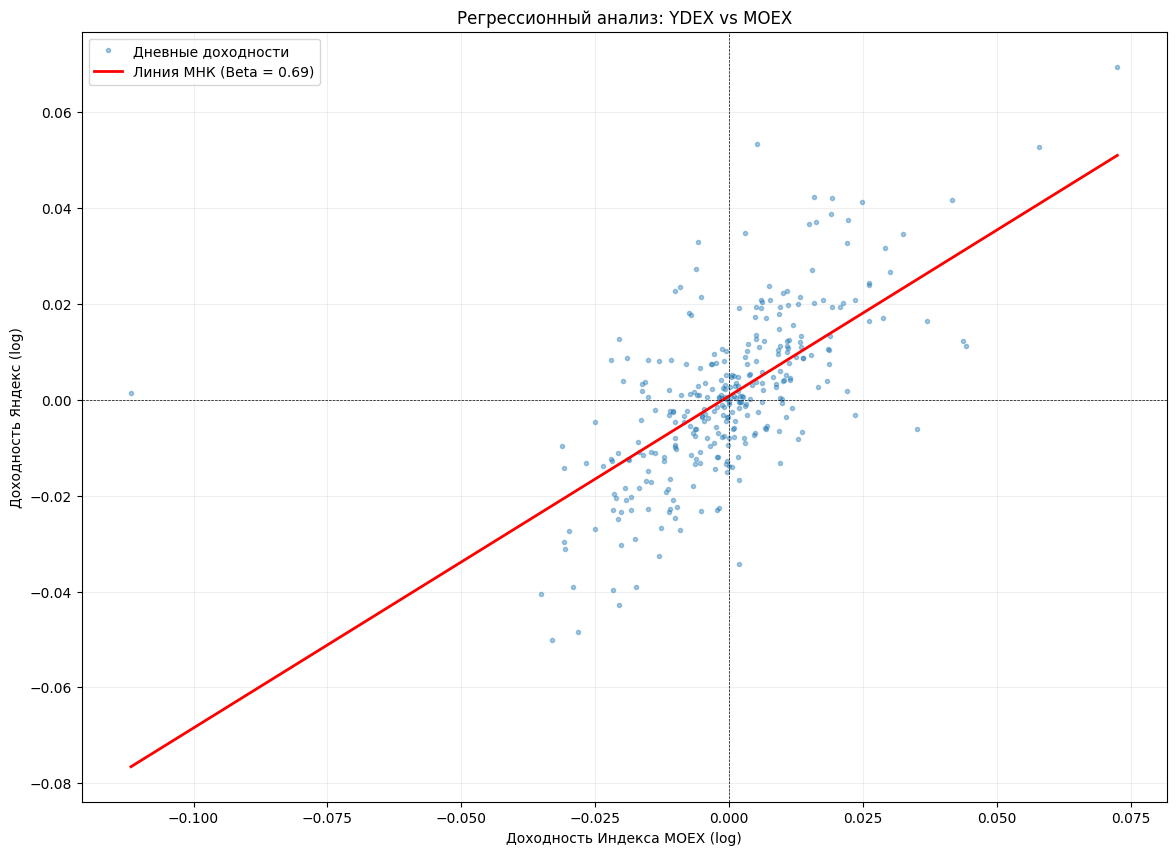

In [25]:
plt.figure(figsize=(14, 10))
plt.plot(general_df["log_return_index"], general_df["log_return_target"], 'o',  markersize=3, alpha=0.4, label="Дневные доходности")

# Генерируем точки для линии регрессии
# Берем минимальное и максимальное значение доходности индекса, чтобы линия прошла через весь график
x_range = np.array([general_df["log_return_index"].min(), general_df["log_return_index"].max()])
# Считаем соответствующие значения y по формуле прямой: y = beta * x + alpha
y_range = b * x_range + a

# Рисуем линию МНК
plt.plot(x_range, y_range, color='red', linewidth=2, label=f"Линия МНК (Beta = {b:.2f})")

plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.xlabel("Доходность Индекса MOEX (log)")
plt.ylabel("Доходность Яндекс (log)")
plt.title("Регрессионный анализ: YDEX vs MOEX")
plt.legend()
plt.grid(True, alpha=0.2)

plt.show()